In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from numpy.linalg import inv
plt.style.use('seaborn-whitegrid')

#Generate ground truth models
#Here we assume the reward is linear in the context.
#each action has a theta which is the weights for the context feature vector
np.random.seed(0)
N_FEATURE = 3
N_ACTION = 5
TRUE_THETAS = np.random.rand(N_ACTION,N_FEATURE) * 5. - 2.
def get_true_thetas(a):
    return TRUE_THETAS[a]
def get_true_reward(x,a):
    return np.dot(x,get_true_thetas(a))
def get_rand_context():
    return np.random.randint(0,5,(N_FEATURE))
def get_optimal_action(x):
    return np.argmax([get_true_reward(x,a) for a in range(N_ACTION)])

print('true thetas for actions')
for a in range(N_ACTION):
    print('action ' + str(a) + ': ' + str(get_true_thetas(a)))


true thetas for actions
action 0: [0.74406752 1.57594683 1.01381688]
action 1: [0.72441591 0.118274   1.22947057]
action 2: [0.18793606 2.458865   2.8183138 ]
action 3: [-0.08279241  1.95862519  0.6444746 ]
action 4: [ 0.84022281  2.62798319 -1.64481971]


In [7]:
#contextual MAB
class Bandit():
    def __init__(self, n_feature, n_action, policy):
        self.policy = policy
        self.thetas = np.zeros((n_action,n_feature))
        self.n_a = n_action
        self.n_f = n_feature
        self.Ds = [np.zeros(3).reshape(1,3)] * self.n_a
        self.Cs = [0] * self.n_a
        
    def pick_action(self,x):
        if self.policy == 'random':
            return np.random.randint(0,self.n_a)
        elif self.policy == 'egreedy':
            if np.random.rand()<0.2:
                return np.random.randint(0,self.n_a)
            else:
                return np.argmax([np.dot(x,self.thetas[a]) for a in range(self.n_a)])
        elif self.policy == 'LinUCB':
            delta = 0.3
            max_E = np.NINF
            best_a = 0
            for a in range(self.n_a):
                D = self.Ds[a]
                A = np.dot(D.T,D) + np.identity(self.n_f)
                A_inverse = inv(A)
                alpha = 1. + np.sqrt(np.log(2./delta)/2.)
                bound = alpha * np.sqrt(np.dot(np.dot(x.T, A_inverse), x))
                E = np.dot(x.T,self.thetas[a]) + bound
                if E > max_E:
                    max_E = E
                    best_a = a
                
            return best_a
        else:
            raise Exception('no policy found')
    def update_model(self,x,a,r):
        d = len(x)
        self.Ds[a] = np.append(self.Ds[a],[x],axis=0)
        self.Cs[a] = np.append(self.Cs[a],r)
        D = self.Ds[a]
        C = self.Cs[a]
        inverse = inv(np.dot(D.T, D) + np.identity(d))
        new_theta = np.dot(np.dot(inverse,D.T), C)
        self.thetas[a] = new_theta
        
    

thetas
action 0: [0.75669913 1.54889775 0.99230133]
action 1: [0.73017446 0.14900576 1.18026309]
action 2: [0.18990987 2.45789877 2.81667537]
action 3: [0.06516996 1.38934531 0.17427493]
action 4: [ 0.83266416  2.62332078 -1.35245754]
thetas
action 0: [0.74588812 1.57240614 1.01319295]
action 1: [0.72348751 0.12228589 1.22499339]
action 2: [0.19799505 2.4527274  2.81008372]
action 3: [-0.07919404  1.95261349  0.64489333]
action 4: [ 0.83796549  2.61596587 -1.63118355]
thetas
action 0: [0.74872136 1.56234804 1.01229549]
action 1: [0.72602946 0.12750513 1.21522714]
action 2: [0.19057436 2.45761236 2.81622364]
action 3: [-0.0553199   1.93402219  0.6423856 ]
action 4: [ 0.84388508  2.61341405 -1.62210433]


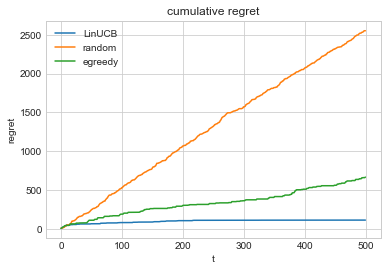

In [19]:
#run simulation
ITERATIONS = 500
def run_experiment(iterations, policy):
    np.random.seed(0)
    regret = 0.
    regret_list = []
    model = Bandit(N_FEATURE, N_ACTION, policy)
    for t in range(iterations):
        context = get_rand_context()
        a = model.pick_action(context)
        r = get_true_reward(context,a)
        model.update_model(context,a,r)
        regret += abs(r - get_true_reward(context,get_optimal_action(context)))
        regret_list.append(regret)
    
    print('thetas')
    for a in range(model.n_a):
        print('action ' + str(a) + ': ' + str(model.thetas[a]))
    plt.plot(regret_list, label=policy)
    return

fig = plt.figure()
ax = plt.axes()
plt.title('cumulative regret')
plt.xlabel('t')
plt.ylabel('regret')

run_experiment(ITERATIONS, 'LinUCB')
run_experiment(ITERATIONS, 'random')
run_experiment(ITERATIONS, 'egreedy')
plt.legend()
